<a href="https://colab.research.google.com/github/sierrarowley/research_fall2020/blob/master/data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import string
import numpy as np
import matplotlib.pyplot as plt
import math

xbound = 10
ybound = 10
point_bound = 1000

def generatedata():
  db = np.empty((xbound, ybound), dtype=object)
  # create random number of points
  for n in range(0, random.randint(1, point_bound)):
    x = random.randint(0, xbound-1)
    y = random.randint(0, ybound-1)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    # at most 10 values per point
    elif len(db[x, y]) < 10:
      db[x, y].append(enc)
  
  return db

generate_dense and generate_sparse are functions that create databases that are specifically dense and sparse. These ensure that some dense and some sparse databases will be used as input to the nn. This also allows there to be a smaller number of points in the database to make the neural net run faster.

In [2]:
extra_point_bound = 50

def generate_dense():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  xsprinkle = []
  ysprinkle = []
  # create point at each index
  for x in range(0, xbound):
    for y in range(0, ybound):
      # encrypt value of point
      randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
      enc = hash(randstring + str(x) + str(y))
      # store encrypted point in the database
      db[x, y] = [enc]
      xvalues.append(x)
      yvalues.append(y)

  # sprinkle random number of extra points around db
  for n in range(0, random.randint(1, extra_point_bound)):
    x = random.randint(0, xbound-1)
    y = random.randint(0, ybound-1)
    xsprinkle.append(x)
    ysprinkle.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))
    db[x, y].append(enc)

  # plt.plot(xvalues, yvalues, 'r.')
  # plt.plot(xsprinkle, ysprinkle, 'b.')
  # plt.show()
  return db


sparse_point_bound = 150

def generate_sparse():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  # create random number of points
  for n in range(0, random.randint(1, sparse_point_bound)):
    x = random.randint(0, xbound-1)
    y = random.randint(0, ybound-1)
    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  # plt.plot(xvalues, yvalues, 'r.')
  # plt.show()
  return db

In [3]:
small_point_bound = 5

def generate_sparse_small():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  # create random number of points
  for n in range(0, random.randint(1, small_point_bound)):
    if n > 2:
      x = random.randint(0, int((xbound-1)/2))
      y = random.randint(0, int((ybound-1)/2))
    else:
      x = random.randint(int((xbound-1)/2), xbound-1)
      y = random.randint(int((ybound-1)/2), ybound-1)
    xvalues.append(x)
    yvalues.append(y)
    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  # plt.plot(xvalues, yvalues, 'b.')
  # plt.show()
  return db


def generate_dense_exact():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []

  # create point at each index
  for x in range(0, xbound):
    for y in range(0, ybound):
      # encrypt value of point
      randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
      enc = hash(randstring + str(x) + str(y))
      # store encrypted point in the database
      db[x, y] = [enc]
      xvalues.append(x)
      yvalues.append(y)

  # plt.plot(xvalues, yvalues, 'r.')
  # plt.show()
  return db


def generate_sparse_cluster():
  db = np.empty((xbound, ybound), dtype=object)
  xvalues = []
  yvalues = []
  x_range = int((xbound-1)/4)

  for n in range(0, random.randint(50, 70)):
    x = random.randint(0, x_range)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  for n in range(0, random.randint(20, 50)):
    x = random.randint(x_range, x_range*2)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  for n in range(0, random.randint(10, 20)):
    x = random.randint(x_range*2, x_range*3)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  for n in range(0, random.randint(1, 10)):
    x = random.randint(x_range*3, x_range*4)
    y = random.randint(0, ybound-1)

    xvalues.append(x)
    yvalues.append(y)

    # encrypt value of point
    randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
    enc = hash(randstring + str(x) + str(y))

    # store encrypted point in the database
    if db[x, y] == None:
      db[x, y] = [enc]
    else:
      db[x, y].append(enc)

  # plt.plot(xvalues, yvalues, 'b.')
  # plt.show()
  return db

In [5]:
from google.colab import files 


uploaded = files.upload()

Saving Crimes_-_Map.csv to Crimes_-_Map (1).csv


In [9]:
import pandas as pd 
import io 

crimesmap = pd.read_csv(io.BytesIO(uploaded['Crimes_-_Map.csv']))
crimesmap.head()

,CASE#,DATE OF OCCURRENCE,BLOCK,IUCR,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,BEAT,WARD,FBI CD,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,JD163753,02/24/2020 08:15:00 PM,031XX W LEXINGTON ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,N,N,1134,24.0,11,NaN,NaN,NaN,NaN,NaN
1,JD212847,04/10/2020 10:56:00 PM,005XX W 103RD ST,0560,ASSAULT,SIMPLE,RESIDENCE,N,N,2232,9.0,08A,1174583.0,1836593.0,41.707001,-87.636288,"(41.707000821, -87.636288063)"
2,JD407638,10/19/2020 09:00:00 AM,009XX W LELAND AVE,0820,THEFT,$500 AND UNDER,APARTMENT,N,N,1914,46.0,06,NaN,NaN,NaN,NaN,NaN
3,JC497784,11/03/2019 11:40:00 AM,032XX N CLARK ST,0860,THEFT,RETAIL THEFT,DEPARTMENT STORE,N,N,1924,44.0,06,NaN,NaN,NaN,NaN,NaN
4,JD242916,05/24/2020 09:00:00 PM,011XX S DELANO CT E,0810,THEFT,OVER $500,RESIDENCE - GARAGE,N,N,123,25.0,06,NaN,NaN,NaN,NaN,NaN


In [18]:
def crimes_data(crimesmap_pd):
  crimesmap = np.array(crimesmap_pd)
  # select x coord and y coord columns from crimes map data set
  crimesmap_xy = crimesmap[:, 12:14]

  # remove all nan rows from data
  row = crimesmap_xy.shape[0] - 1
  while row >= 0:
    if math.isnan(crimesmap_xy[row, 0]) or math.isnan(crimesmap_xy[row, 1]) or crimesmap_xy[row, 0] == 0:
      crimesmap_xy = np.delete(crimesmap_xy, row, axis=0)
    row -= 1

  # take first 150 data entries
  crimesmap_xy = crimesmap_xy[:20, :]

  # normalize data so smallest entry is equivalent to 0
  norm_crimesmap = np.empty_like(crimesmap_xy)
  db_min = np.argmin(crimesmap_xy, axis=0)
  print(crimesmap_xy)
  print(db_min)
  print(crimesmap_xy[db_min[0],0], crimesmap_xy[db_min[1],1])
  min_0 = crimesmap_xy[db_min[0],0]
  min_1 = crimesmap_xy[db_min[0],1]
  for r in range(crimesmap_xy.shape[0]):
    if crimesmap_xy[r, 1] - min_1 >= 0:
      norm_crimesmap[r, 0] = crimesmap_xy[r, 0] - min_0
      norm_crimesmap[r, 1] = crimesmap_xy[r, 1] - min_1

  
  print(norm_crimesmap)


  # # get max x and y coordinates to determine size of database
  # db_maxsize = np.argmax(norm_crimesmap, axis=0)
  # db = np.empty((int(norm_crimesmap[db_maxsize[0],0]), int(norm_crimesmap[db_maxsize[1], 1])), dtype=object)

  # # add each x, y coordinate to the database as a hashed value
  # for n in range(0, norm_crimesmap.shape[0]):
  #   x = int(norm_crimesmap[n, 0])
  #   y = int(norm_crimesmap[n, 1])
  #   randstring = ''.join(random.choices(string.ascii_letters + string.digits, k=100))
  #   enc = hash(randstring + str(x) + str(y))
  #   # store encrypted point in the database
  #   if db[x, y] == None:
  #     db[x, y] = [enc]
  #   else:
  #     db[x, y].append(enc)

  return db

crimes_data(crimesmap)

[[1174583.0 1836593.0]
 [1150531.0 1906583.0]
 [1164774.0 1862584.0]
 [1165894.0 1903574.0]
 [1168654.0 1936401.0]
 [1180030.0 1862317.0]
 [1171590.0 1887793.0]
 [1163124.0 1934080.0]
 [1192034.0 1860809.0]
 [1146821.0 1910272.0]
 [1156097.0 1904592.0]
 [1141204.0 1905067.0]
 [1185263.0 1871635.0]
 [1192830.0 1858662.0]
 [1161661.0 1948630.0]
 [1145129.0 1915558.0]
 [1148588.0 1910315.0]
 [1175325.0 1821358.0]
 [1157088.0 1947086.0]
 [1162779.0 1910442.0]]
[11 17]
1141204.0 1821358.0
[[None None]
 [9327.0 1516.0]
 [None None]
 [None None]
 [27450.0 31334.0]
 [None None]
 [None None]
 [21920.0 29013.0]
 [None None]
 [5617.0 5205.0]
 [None None]
 [0.0 0.0]
 [None None]
 [None None]
 [20457.0 43563.0]
 [3925.0 10491.0]
 [7384.0 5248.0]
 [None None]
 [15884.0 42019.0]
 [21575.0 5375.0]]


NameError: ignored

The database is classified as either sparse (0) or dense (1). produce_leakage() performs every possible query of the database and saves the results from those queries in a list. The list is returned at the end.

In [47]:
max_rect_l = 5
max_rect_w = 5

def produce_leakage(db):
  leakage = []
  empty_query_rows = [] # keep track of empty rows(queries) for padding purposes
  query_num = 0 # keep track of row(query) number for empty_query_rows
  querylen = 0
  # all possible size rectangle queries.
  for l in range(1, max_rect_l+1):
    for w in range(1, max_rect_w+1):
      # all possible starting points of the rectangle query
      for x in range(0, xbound):
        # dont perform query if it is out of bounds
        if x+l > xbound:
          break
        for y in range(0, ybound):
          if y+w > ybound:
            break

          curr_query = []
          # loop through current query in the database
          for i in range(x, x+l):
            for j in range(y, y+w):
              # if a point(s) exists at this location in database, add it to the current query
              if db[i, j] != None:
                curr_query.extend(db[i, j])

          # if query is empty, then add [-1] to represent empty         
          if not curr_query:
            leakage.append([-1])
            # keep track of empty queries for padding later
            empty_query_rows.append(query_num)
          # else add query leakage to entire leakage list
          else :
            leakage.append(curr_query)

          # keep track of longest query length for creating input array
          if len(curr_query) > querylen:
            querylen = len(curr_query)
          query_num += 1

  return (leakage, empty_query_rows, querylen)


def classify(db):
  db_density = 0 # keep track of how many indices in db are empty for classification
  for x in range(0, xbound):
      for y in range(0, ybound):
        # count number of empty indices in database to find density classification
        if db[x, y] == None:
          db_density += 1

  density = (100 - db_density)/100
  dense_class = 0
  if density >= 0.4 and density < 1:
    dense_class = 1
  elif density == 1:
    dense_class = 2

  return dense_class

create_database() calls generate_dense() or generate_sparse() (depending on the input parameter) and produce_leakage(), which creates the database and the search query leakages from that database. It then takes the returned list of leakages and transforms it into a 2D numpy array with dimensions (number of queries, length of longest query). All queries with a length shorter than the longest are padded with 0's at the end. Each index of the array represents hashed value of a point in a query. create_database() returns the numpy array, which represents one input to the neural net, and the classification of the database.

In [48]:
def create_database(db_func):
  db = None
  if db_func == "dense":
    db = generate_dense()
  elif db_func == "dense_exact":
    db = generate_dense_exact()
  elif db_func == "sparse":
    db = generate_sparse()
  elif db_func == "sparse_small":
    db = generate_sparse_small()
  else:
    db = generate_sparse_cluster()

  leakage, empty_rows, querylen = produce_leakage(db)
  c = classify(db)
  
  numqueries = len(leakage)
  
  input = np.empty((numqueries, querylen))
  for x in range(0, numqueries):
    q = np.array(leakage[x])
    # empty rows are padded with -1 to distinguish them
    if x in empty_rows:
      input[x] = np.pad(q, (0, querylen-len(q)), 'constant', constant_values=(0, -1))
    # all other queries are padded with 0 to be same shape
    else:
      input[x] = np.pad(q, (0, querylen-len(q)), 'constant', constant_values=(0, 0))

  # shuffle leakage to make order and location of queries less obvious
  np.random.shuffle(input)
  
  return (input, c)

create_nn_data() creates a specified number of databases that will be used in the training and testing sets for the neural net. It pads each input array (from create_database) so they are all of the same size. It returns an array of inputs of size (number of inputs, number of queries, number of items in query) and an array of the labels.

In [49]:
def create_nn_data(num_inputs):
  # num_dense = int(num_inputs*0.4)
  data = [] # list to store each database
  labels = np.zeros((num_inputs))
  numqueries = 0
  querylen = 0

  # select random indices to be made into dense databases
  # indices = np.arange((num_inputs))
  # np.random.shuffle(indices)
  # dense_indices = indices[:num_dense]

  db_func_list = ["dense", "dense_exact", "sparse", "sparse_small", "sparse_cluster"]

  # create all databases for input
  for n in range(0, num_inputs):
    # # dense_indices contains random values of n to be made dense databases
    # if n in dense_indices:
    #   database, label = create_database(1)
    #   data.append(database)
    #   labels[n] = label
    # # all others are sparse
    # else:
    #   database, label = create_database(0)
    #   data.append(database)
    #   labels[n] = label

    db_func = random.choice(db_func_list)
    database, label = create_database(db_func)
    data.append(database)
    labels[n] = label

    # find largest shape to later pad all databases to be same size
    if database.shape[0] > numqueries:
      numqueries = database.shape[0]
    if database.shape[1] > querylen:
      querylen = database.shape[1]

  inputs = np.empty((num_inputs, numqueries, querylen))

  # pad each database
  for i in range(0, len(data)):
    d = data[i]
    d = np.pad(d, ((0, 0), (0, max(querylen - d.shape[1], 0))), 'constant', constant_values=(0, 0))
    inputs[i] = d

  return inputs, labels

Time to make the neural net! I will be using tensorflow with keras

In [10]:
import tensorflow as tf
from tensorflow import keras

In [51]:
# preprocess data
n = 1500
inputs, labels = create_nn_data(n)

train_inputs = inputs[0:int(n*.8), :, :, None]
train_labels = labels[0:int(n*.8)]
test_inputs = inputs[int(n*.8):n, :, :, None]
test_labels = labels[int(n*.8):n]

print("train inputs: ", train_inputs.shape, "train labels: ", train_labels.shape)
print("test inputs: ", test_inputs.shape, "test labels: ", test_labels.shape)

# create model
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(96, 3, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Conv2D(96, 3, strides=2, padding='same', activation='relu', kernel_regularizer='L2'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_inputs, train_labels, epochs=7)

test_loss, test_acc = model.evaluate(test_inputs,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

train inputs:  (1200, 1600, 74, 1) train labels:  (1200,)
test inputs:  (300, 1600, 74, 1) test labels:  (300,)
Epoch 1/7
38/38 [==============================] - 105s 3s/step - loss: 9457431012704256.0000 - accuracy: 0.6642
Epoch 2/7
38/38 [==============================] - 105s 3s/step - loss: 53204263895040.0000 - accuracy: 0.8167
Epoch 3/7
38/38 [==============================] - 106s 3s/step - loss: 16396721324032.0000 - accuracy: 0.8717
Epoch 4/7
38/38 [==============================] - 107s 3s/step - loss: 8274314264576.0000 - accuracy: 0.9058
Epoch 5/7
38/38 [==============================] - 104s 3s/step - loss: 6825343713280.0000 - accuracy: 0.9317
Epoch 6/7
38/38 [==============================] - 103s 3s/step - loss: 5077773844480.0000 - accuracy: 0.9383
Epoch 7/7
38/38 [==============================] - 104s 3s/step - loss: 2956442992640.0000 - accuracy: 0.9542
10/10 - 6s - loss: 24424388493312.0000 - accuracy: 0.8233

Test accuracy: 0.8233333230018616


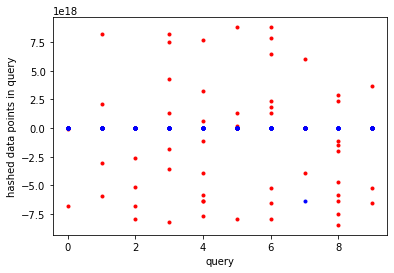

In [33]:
data, labels = create_nn_data(10)
def plot_data():
  #for i in range(0, data.shape[0]):
  plt.plot(data[0, 0:10, 0:10], 'r.')
  plt.plot(data[1, 0:10, 0:10], 'b.')
  plt.xlabel('query')
  plt.ylabel('hashed data points in query')
  plt.show()

plot_data()